In [10]:
from model.network.gaitset_noglobal import SetNet
import torch.optim as optim
import torch.nn as nn
import torch
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [11]:
encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

model_name = 'GaitSet'
encoder.load_state_dict(torch.load('C:/Users/TUF/Downloads/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-10000-encoder.ptm'))

<All keys matched successfully>

In [12]:
encoder.eval()

from model.initialization import initialize_data
from config import conf

train_source, test_source = initialize_data(conf, train = False, test = True)

Initializing data source...
Loading test data...
Data initialization complete.


In [13]:
from copy import deepcopy
import numpy as np

# train_source, test_source = initialize_data(conf, train = False, test = False)
data_config = conf['data']
model_config = conf['model']
model_param = deepcopy(model_config)
model_param['train_source'] = None
model_param['test_source'] = test_source
model_param['train_pid_num'] = data_config['pid_num']
batch_size = int(np.prod(model_config['batch_size']))
model_param['save_name'] = '_'.join(map(str,[
    model_config['model_name'],
    data_config['dataset'],
    data_config['pid_num'],
    data_config['pid_shuffle'],
    model_config['hidden_dim'],
    model_config['margin'],
    batch_size,
    model_config['hard_or_full_trip'],
    model_config['frame_num'],
]))
restore_iter = 108100

In [14]:
import torch.utils.data as tordata
from model.model import Model

model = Model(**model_param)
data_loader = tordata.DataLoader(
            dataset=test_source,
            batch_size=1,
            sampler=tordata.sampler.SequentialSampler(test_source),
            collate_fn=model.collate_fn,
            num_workers=model.num_workers)

In [15]:
feature_list = list()
view_list = list()
seq_type_list = list()
label_list = list()
for i, data in enumerate(data_loader):
    seq, view, seq_type, label, batch_frame = data

    seq[0] = model.np2var(seq[0])
    batch_frame = model.np2var(batch_frame)

    feature, _ = encoder(*seq, batch_frame)
    feature_list.append(feature.view(1, -1).data.cpu().numpy())
    view_list += view
    seq_type_list += seq_type
    label_list += label

In [16]:
data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
feature, view, seq_type, label = data
label = np.array(label)
view_list = list(set(view))
view_list.sort()
view_num = len(view_list)
sample_num = len(feature)

In [17]:
feature.shape

(880, 7936)

In [18]:
def plot_feature(type, same_label=True, num=20):
    # colors = plt.cm.tab20(np.linspace(0, 1, 20))
    if not same_label:
        colors = plt.cm.nipy_spectral(np.linspace(0, 1, num))
    else:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    pca = PCA(n_components=2)
    reducer = umap.UMAP(n_components=2, random_state=21)

    if type == 'umap':
        clusters = reducer.fit_transform(feature)
    elif type == 'tsne':   
        clusters = tsne.fit_transform(feature)
    elif type == 'pca':
        clusters = pca.fit_transform(feature)
    else:
        clusters = feature.reshape(-1, 256)
    # Create one figure for all plots
    plt.figure(figsize=(8, 8))

    for i in range(880):
        x = clusters[i, 0]
        y = clusters[i, 1]

        if not same_label:
            plt.scatter(x, y, color=colors[i], s=10)
        else:
            plt.scatter(x, y, color=colors[int(label[i]) - 117], s=5)
    plt.grid(True)
    # plt.legend()
    plt.show()

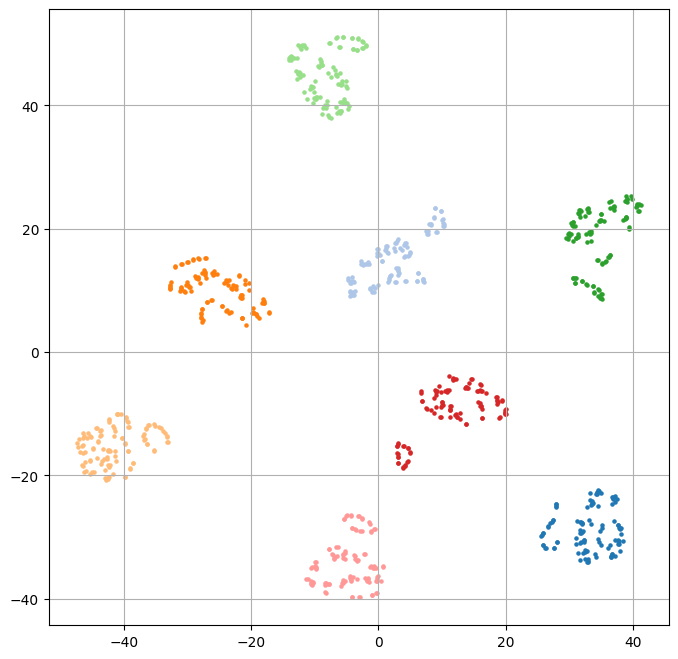

In [19]:
plot_feature('tsne', same_label=True)

In [20]:
probe_seq_dict =  [['nm-05', 'nm-06'], ['bg-01', 'bg-02'], ['cl-01', 'cl-02']]
gallery_seq_dict = [['nm-01', 'nm-02', 'nm-03', 'nm-04']]

In [21]:
def euclid_dist(a, b):
    a2 = np.sum(a**2, axis=1, keepdims=True)
    b2 = np.sum(b**2, axis=1, keepdims=True)
    dist = a2 + b2.T - 2 * a @ b.T
    dist = np.sqrt(np.maximum(0, dist))
    return dist
    

In [22]:
acc = np.zeros([len(probe_seq_dict), view_num, view_num])
for (p, probe_seq) in enumerate(probe_seq_dict):
    for gallery_seq in gallery_seq_dict:
        for (v1, probe_view) in enumerate(view_list):
            for (v2, gallery_view) in enumerate(view_list):
                gseq_mask = np.isin(view, gallery_view) & np.isin(seq_type, gallery_seq)
                pseq_mask = np.isin(view, probe_view) & np.isin(seq_type, probe_seq)

                gseq = feature[gseq_mask]  # 32, (62 x 256)
                pseq = feature[pseq_mask]   # 16, (62 x 256)

                dist = euclid_dist(pseq, gseq) # 16, 32
                idx = np.argmin(dist, axis=1)  # 16

                gseq_label = label[gseq_mask]  # 32,
                pseq_label = label[pseq_mask]  # 16,
                # print(idx)
                # print(np.sum(gseq_label[idx] == pseq_label) * 100 / 16)
                acc[p, v1, v2] = np.sum(gseq_label[idx] == pseq_label) * 100 / 16

    #             break
    #         break
    #     break
    # break
    

In [23]:
print(acc)

[[[100.   100.    87.5   87.5   87.5   87.5   87.5   87.5  100.   100.
   100.  ]
  [100.   100.   100.   100.    87.5  100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [ 93.75  93.75 100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  ]
  [100.   100.   100.   100.    81.25  87.5  100.   100.   100.   100.
   100.  ]]

 [[100.   100.   100.    87.5   87.5   87.5   87.5   87.5  100.   100.
   100.  ]
  [100.   100.

In [24]:
np.sum(acc) / (len(probe_seq_dict) * view_num * view_num)

95.55785123966942